# Udacity Capstone Project
## Supervised Learning
## 3D Point Cloud Data Classification

## Introduction
The purpose of this project is to classify points within a 3D point cloud. In particular, this project aims to identify points that are linear / pipe-like. 

The 3D point cloud data is stored in one / many files named foo.flt5.ply. The foo.flt5.ply file contains a series of (x,y,z,intensity) point cloud points from a scan of a scene that contains walls, floor, other objects and the linear/pipe-like object we are interested in. 

For the classifier, this project uses supervised learning. In the training data, points representing the pipe-like object are hand segmented. The points representing the pipe-like object are stored in a file foo-Linear.ply. 

## Loading the Data
Run the code cell below to load necessary Python libraries and load the 3D point cloud data. This section loads the full point cloud file (foo.flt5.ply), the file containing the hand-segmented points (foo-Linear.ply) Note that the last column from this dataset, `'class_id'`, is the target label. The point cloud data is loaded from a .flt5.ply file. All other columns are features about each point.

In [1]:
from os import listdir
from os.path import isfile, join

def get_training_files(data_file_path):
    """
    This function returns the training file names from a directory.

    Parameters
    -------------------
    data_file_path: string
        This is the path to the data directory

    Return Values
    -------------------
    point_cloud_file_names:
        The names of the .flt5.ply point cloud files in the directory

    linear_file_names:
        The names of the -Linear.ply files
    """
    
    only_files = [f for f in listdir(data_file_path) if isfile(join(data_file_path, f))]
    linear_file_string = "-Linear.ply"
    linear_file_names = [f for f in only_files if f[-len(linear_file_string):] == linear_file_string]
    point_cloud_file_string = ".flt5.ply"
    point_cloud_file_names = [f for f in only_files if f[-len(point_cloud_file_string):] == point_cloud_file_string]
    
    return point_cloud_file_names, linear_file_names

In [2]:
from scipy import spatial

def load_class_id(class1_points_file_name, class2_points_file_name, num_point_cloud_points, kdtree):
    """
    This function loads the hand labeled data and returns a class_id label for the point cloud points.

    Parameters
    -------------------
    class1_points_file_name: string
        This is the path to the class 1 point cloud data

    class2_points_file_name: string
        This is the path to the class 2 point cloud data
        
    kdtree: KD Tree
        This is the kd tree used to find the point in the point cloud that
        is closest to the hand labeled point. 

    Return Values
    -------------------
    class_id: np.array
        The class ID of each point in the point cloud. The index in the array
        corresponds to the index of the point cloud point
    """

    # Read in the class 1 data points
    data = pc.read_ply_file(class1_points_file_name)

    class_points = np.array(data[['x','y','z']])

    # Create the class id array
    class_id = np.zeros(num_point_cloud_points, dtype=np.int)

    # For each point, find its index in the point cloud and set its class_id
    for query_point in class_points:
        point_distance, point_index = kdtree.query(query_point, k=1, p=np.inf)
        class_id[point_index] = 1

    # Classify the class 2 points if they are there
    if not (class2_points_file_name is None):
        data = pc.read_ply_file(class2_points_file_name)
        class_points = np.array(data[['x','y','z']])
        for query_point in class_points:
            point_distance, point_index = kdtree.query(query_point, k=1, p=np.inf)
            class_id[point_index] = 2

    return class_id

def load_training_data(point_cloud_file_name, class1_points_file_name, class2_points_file_name=None):
    """
    This function loads the training data. The training data consists of
    the point cloud data, and a set of hand classified points. For each
    point in the point cloud, its features are calculated and it is 
    given a class_id identifying its hand classified object type. The hand
    classified points are labeled as class 1 and (optionally) class 2

    Parameters
    -------------------
    point_coud_file_name: string
        point cloud file name

    class1_points_file_name: string
        point cloud file name containing the class 1 points

    class2_points_file_name: string
        point cloud file name containing the class 2 points

    Return Values
    -------------------
    data: pandas DataFrame
        The training data. The point cloud data is stored in columns
        'x','y','z','intensity' and the class label is stored in
        'class_id'

    """

    # Load the point cloud data
    data = pc.read_ply_file(point_cloud_file_name)

    point_cloud_points = np.array(data[['x','y','z']])
    point_cloud_intensities = np.array(data['intensity'])

    # Build a KD tree to make finding nearest neighbors faster. Use only x,y,z points (not intensity) to build tree
    kdtree = spatial.cKDTree(point_cloud_points)
    
    # Calculate the point cloud features
    data = pc.calculate_features(point_cloud_points, point_cloud_intensities, kdtree)
    
    # Load the hand labeled class data
    class_id = load_class_id(class1_points_file_name, class2_points_file_name, point_cloud_points.shape[0], kdtree)
    data['class_id'] = pd.Series(class_id, index=data.index)

    return data

In [3]:
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score
import processPly as pc
import matplotlib.pyplot as plt
%matplotlib inline

data_file_path = "../data/stationary/"


# Find the training data file names
point_cloud_file_names, linear_file_names = get_training_files(data_file_path)

print 'Training Data Files:'
print 'Point Cloud Files:'
print point_cloud_file_names
print 'Hand Segmented File Names'
print linear_file_names

# Load all of the training data
data = pd.DataFrame()
for point_cloud_file_name, linear_file_name,  in zip(point_cloud_file_names, linear_file_names):
    new_data = load_training_data(data_file_path + point_cloud_file_name,
                                  data_file_path + linear_file_name)
    data = data.append(new_data, ignore_index=True)

# Remove the point cloud x,y,z data from the data frame. Those will not be used as training features
point_cloud_points = data[['x','y','z','intensity']]
del data['x']
del data['y']
del data['z']
del data['intensity']

print 'Data Successfully Loaded'


Training Data Files:
Point Cloud Files:
['1488571046.526833.flt5.ply']
Hand Segmented File Names
['1488571046.526833-Linear.ply']
Data Successfully Loaded


### Implementation: Data Exploration
In this section, the data is explored manually. Plots and statistics are generated to get a feel for how the data is behaving.

In [55]:
import itertools
def scatterplot_matrix_classId(data0, data1, loglog=False, filter_percentile=False, **kwargs):
    """
    Adapted from http://stackoverflow.com/questions/7941207/is-there-a-function-to-make-scatterplot-matrices-in-matplotlib
    Plots a scatterplot matrix of subplots.  Each row of "data" is plotted
    against other rows, resulting in a nrows by nrows grid of subplots with the
    diagonal subplots labeled with "names".  Additional keyword arguments are
    passed on to matplotlib's "plot" command. Data in the data0 are plotted as blue dots
    Data in the data1 are plotted as red dots. 

    Parameters
    -------------------
    data0: pd.DataFrame
        data for class 0 objects

    data1: pd.DataFrame
        data for class 1 objects
        
    loglog: Bool
        True to plot as log log
        
    filter_percentile: Bool
        True to filter only data in 25-75 percentile
        
    kwargs
        plotting arguments

    Return Values
    -------------------
    fig: 
        Returns the matplotlib figure object containg the subplot grid.

    """
    names = data0.columns
    numvars = len(names)
    fig, axes = plt.subplots(nrows=numvars, ncols=numvars, figsize=(8,8))
    fig.subplots_adjust(hspace=0.0, wspace=0.0)

    for ax in axes.flat:
        # Hide all ticks and labels
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        # Set up ticks only on one side for the "edge" subplots...
        if ax.is_first_col():
            ax.yaxis.set_ticks_position('left')
        if ax.is_last_col():
            ax.yaxis.set_ticks_position('right')
        if ax.is_first_row():
            ax.xaxis.set_ticks_position('top')
        if ax.is_last_row():
            ax.xaxis.set_ticks_position('bottom')

    # Plot the data.
    for i, j in zip(*np.triu_indices_from(axes, k=1)):
        for x, y in [(i,j), (j,i)]:
            var1 = data0.columns[x]
            var2 = data0.columns[y]
            axes[x,y].plot(data0[var1], data0[var2], 'b.', **kwargs)
            axes[x,y].plot(data1[var1], data1[var2], 'r.', **kwargs)
            if loglog:
                axes[x,y].set_yscale('log')
                axes[x,y].set_xscale('log')
            if filter_percentile:
                xval = np.concatenate((np.array(data0[var1]),np.array(data1[var1])))
                yval = np.concatenate((np.array(data0[var2]),np.array(data1[var2])))
                axes[x,y].set_xlim([np.percentile(xval,25), np.percentile(xval,75)])
                axes[x,y].set_ylim([np.percentile(yval,25), np.percentile(yval,75)])


    # Label the diagonal subplots...
    for i, label in enumerate(names):
        axes[i,i].annotate(label, (0.5, 0.5), xycoords='axes fraction',
                ha='center', va='center')

    # Turn on the proper x or y axes ticks.
    for i, j in zip(range(numvars), itertools.cycle((-1, 0))):
        axes[j,i].xaxis.set_visible(True)
        axes[i,j].yaxis.set_visible(True)

    return fig



In [5]:
print 'Class 0 (Other) Data Decscription'
print(data[data['class_id']==0][data.columns[:-1]].describe())

print 'Class 1 (Target) Data Description'
print(data[data['class_id']==1][data.columns[:-1]].describe())


Class 0 (Other) Data Decscription
          pointness   surfaceness    linearness   cos_tangent   sin_tangent  \
count  1.479400e+04  14794.000000  1.479400e+04  14794.000000  14794.000000   
mean   1.094056e-04      0.000614  4.707240e-04      0.222240      0.150595   
std    3.023028e-04      0.001393  2.813322e-03      0.303284      0.342776   
min    3.677823e-07      0.000014  8.434865e-07      0.000452     -0.997971   
25%    7.722005e-06      0.000443  3.924678e-05      0.039213      0.015550   
50%    9.385035e-06      0.000496  7.374171e-05      0.083733      0.056246   
75%    5.913376e-05      0.000581  4.288475e-04      0.217159      0.158304   
max    2.007596e-02      0.120747  1.641628e-01      1.000000      0.999999   

         cos_normal    sin_normal  
count  14794.000000  14794.000000  
mean       0.865914      0.010645  
std        0.247973      0.200242  
min        0.001863     -0.998708  
25%        0.887621     -0.046560  
50%        0.993344      0.063703  
75

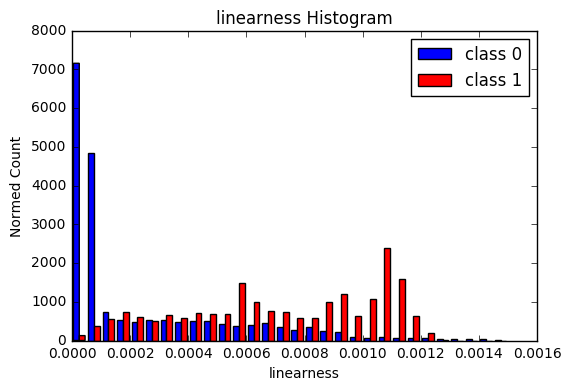

In [36]:
feature='linearness'
plt.hist([data[data['class_id']==0][feature],data[data['class_id']==1][feature]], color=['b','r'],
         range=[0.0000, 0.0015], normed=True, label=['class 0', 'class 1'], bins=30)
plt.legend()
plt.title(feature + ' Histogram')
plt.xlabel(feature)
plt.ylabel('Normed Count')


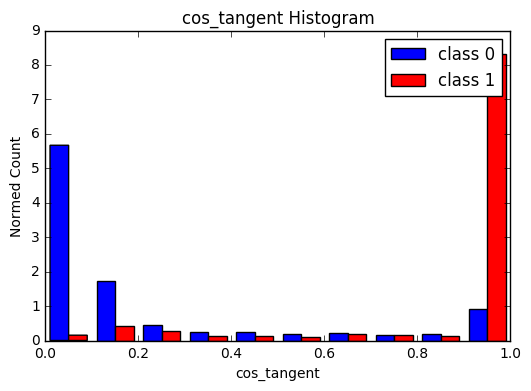

In [33]:
feature='cos_tangent'
plt.hist([data[data['class_id']==0][feature],data[data['class_id']==1][feature]], color=['b','r'],
         range=[0.0000, 1.0], normed=True, label=['class 0', 'class 1'], bins=10)
plt.legend()
plt.title(feature + ' Histogram')
plt.xlabel(feature)
plt.ylabel('Normed Count')

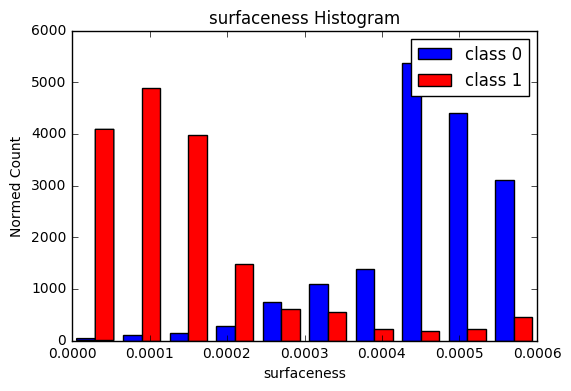

In [60]:
feature='surfaceness'
plt.hist([data[data['class_id']==0][feature],data[data['class_id']==1][feature]], color=['b','r'],
         range=[0.0000, 0.0006], normed=True, label=['class 0', 'class 1'], bins=10)
plt.legend()
plt.title(feature + ' Histogram')
plt.xlabel(feature)
plt.ylabel('Normed Count')

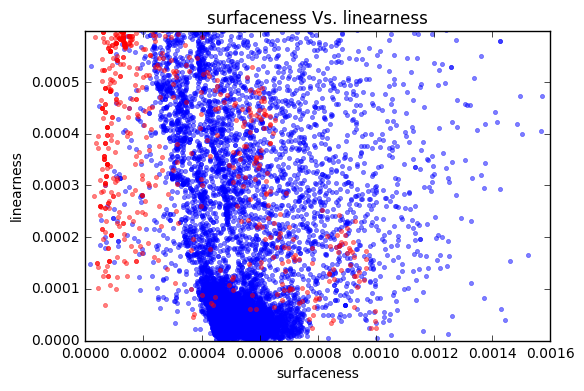

In [64]:
feature1 = 'surfaceness'
feature2 = 'linearness'
d0x = data[data['class_id']==0][feature1]
d0y = data[data['class_id']==0][feature2]
d1x = data[data['class_id']==1][feature1]
d1y = data[data['class_id']==1][feature2]
plt.plot(d0x, d0y, 'b.', alpha=0.5)
plt.plot(d1x, d1y, 'r.', alpha=0.5)
plt.gca().set_ylim([0,0.0006])
plt.gca().set_xlim([0, 0.0016])
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title(feature1 + ' Vs. ' + feature2)

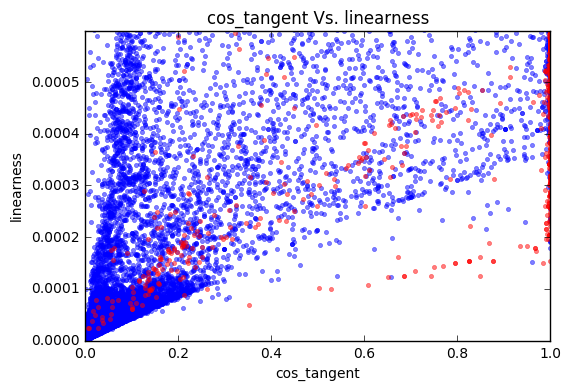

In [68]:
feature1 = 'cos_tangent'
feature2 = 'linearness'
d0x = data[data['class_id']==0][feature1]
d0y = data[data['class_id']==0][feature2]
d1x = data[data['class_id']==1][feature1]
d1y = data[data['class_id']==1][feature2]
plt.plot(d0x, d0y, 'b.', alpha=0.5)
plt.plot(d1x, d1y, 'r.', alpha=0.5)
plt.gca().set_ylim([0, 0.0006])
plt.gca().set_xlim([0, 1])
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title(feature1 + ' Vs. ' + feature2)



Scatter Matrix for Classes. Target Points in Red


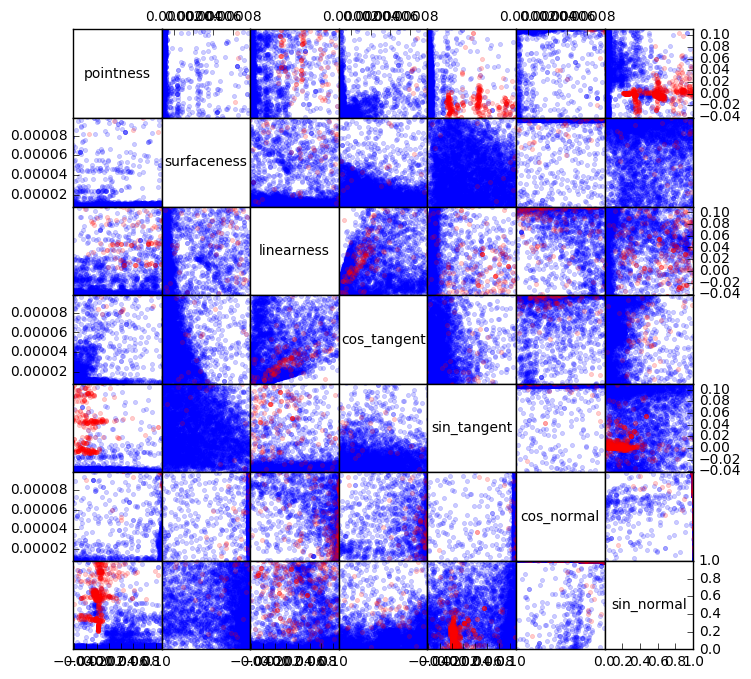

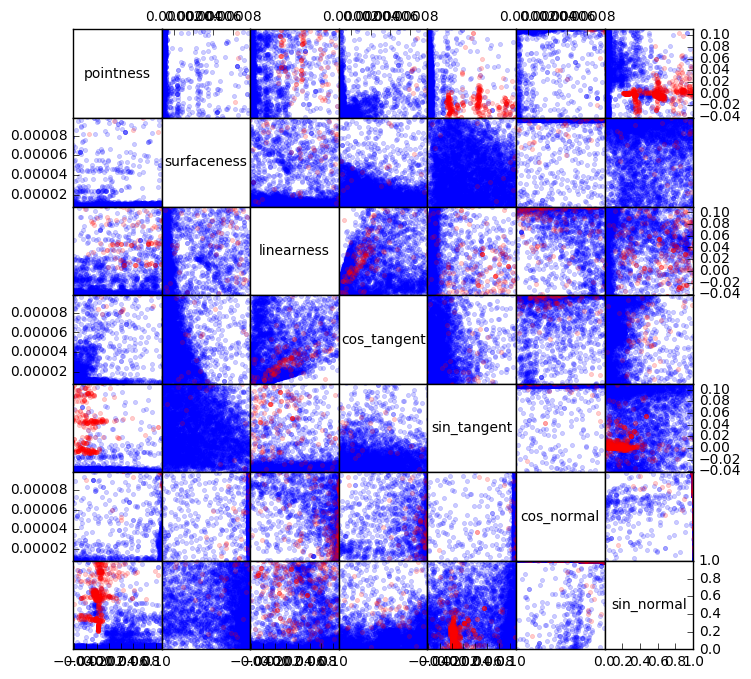

In [56]:
print '\n\nScatter Matrix for Classes. Target Points in Red'
scatterplot_matrix_classId(data[data['class_id']==0][data.columns[:-1]], 
                           data[data['class_id']==1][data.columns[:-1]], loglog=False, alpha=0.2)


Looking at the above scatter plot, the pipe-like points (shown in red) and other points (shown in blue) are clustered together. This is a good sign for classification. Some features pairs such as (linearness, cos_tangent) and (cos_normal, sin_normal) seem to have a linear relationship, so are somewhat redundant. This will be explored further below.

## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns

In [7]:
# Extract feature columns
feature_cols = list(data.columns[:-1])

# Extract target column 'class_id'
target_col = 'class_id' 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = data[feature_cols]
y_all = data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()

Feature columns:
['pointness', 'surfaceness', 'linearness', 'cos_tangent', 'sin_tangent', 'cos_normal', 'sin_normal']

Target column: class_id

Feature values:
   pointness  surfaceness  linearness  cos_tangent  sin_tangent  cos_normal  \
0   0.000134     0.000313    0.000084     0.218129     0.155868    0.988950   
1   0.000157     0.000099    0.000151     0.960559     0.082704    0.604203   
2   0.000132     0.000325    0.000411     0.989396    -0.145244    0.743649   
3   0.000142     0.000206    0.000552     0.999021     0.044244    0.354133   
4   0.000102     0.000385    0.000287     0.727925    -0.153911    0.909783   

   sin_normal  
0   -0.148248  
1   -0.183079  
2   -0.265045  
3   -0.119026  
4   -0.415084  


PCA Explained Variance Cumulative Sum
[  54.33796407   85.33291196   94.17211562   99.99765178   99.99983185
   99.99998489  100.        ]


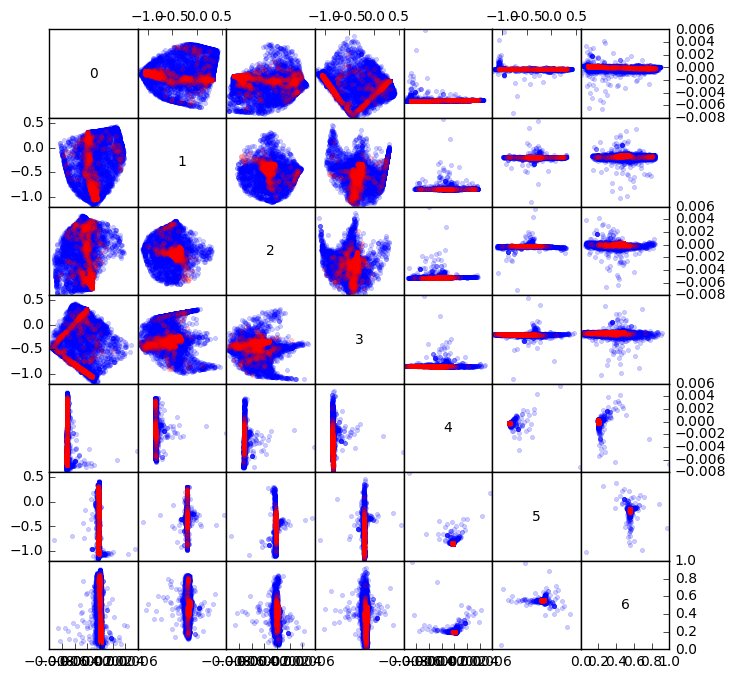

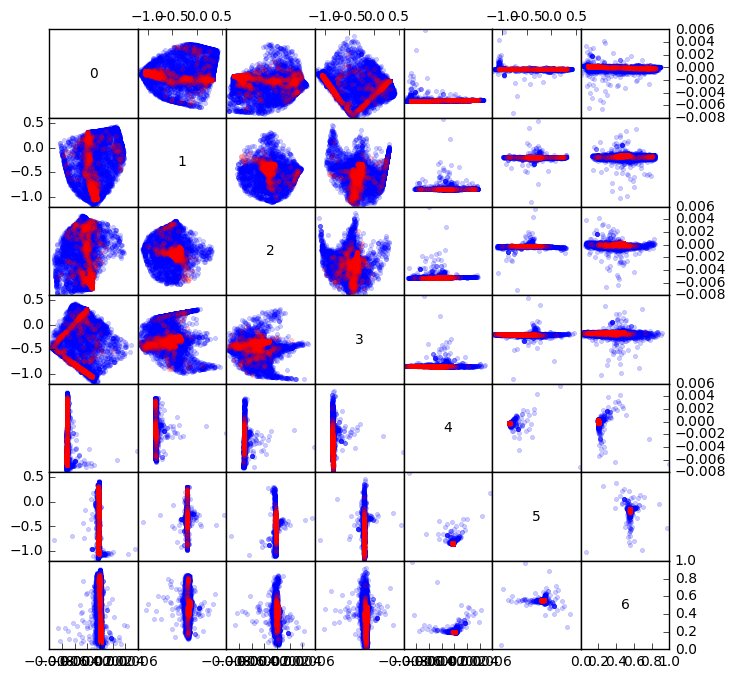

In [8]:
# Try PCA decomposition
X_class1 = X_all[y_all==1]
X_class0 = X_all[y_all==0]

from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_all)

print 'PCA Explained Variance Cumulative Sum'
print np.cumsum(pca.explained_variance_ratio_*100)

# pca = PCA(n_components = 3)
# pca.fit(X_all)

a = pca.transform(X_class1)
b = pca.transform(X_class0)

a_data = pd.DataFrame(a)
b_data = pd.DataFrame(b)

plt.figure()
scatterplot_matrix_classId(b_data, a_data, loglog=False, alpha=0.2)


Looking at the PCA, 94% of the data's variance is explained by the first 3 eigen vectors. This verifies that there is a linear relationship between much of the data. This verifies what we saw in the scatter plot of the raw data. However, if PCA is applied to the training data, the resulting classification performance drops from an F1 score of ~90 to ~70. Also, applying a logarithm transform to the data hurt results as well. Therefore, for the remainder of the analysis, just the raw input data is used in classification.

### Implementation: Training and Testing Data Split
For training and testing, the data will be split into a training set of 75% of the data and test set of 25%. The training data is stored in X_train (features), y_train (class). The test data is stored in X_test and y_test.


In [9]:
from sklearn.cross_validation import train_test_split

# Shuffle and split the dataset into the number of training and testing points above
X_train, X_test , y_train, y_test = train_test_split(X_all, y_all, train_size = 0.75, random_state = 42)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 12165 samples.
Testing set has 4056 samples.


## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. For each model chosen*
- Describe one real-world application in industry where the model can be applied. *(You may need to do a small bit of research for this — give references!)* 
- What are the strengths of the model; when does it perform well? 
- What are the weaknesses of the model; when does it perform poorly?

- What makes this model a good candidate for the problem, given what you know about the data?

**Answer: **
I have chosen AdaBoost, K nearest neighbors and Support Vector Classifier.

Looking at plots of the data (Figure 1-3), there is not a simple boundary separating the students who graduate vs those who fail. Therefore, classifiers that are able to handle complex decision boundaries may perform best. Looking at the size of the raw data that we are classifying, there are 265 students who passed and 130 who failed. The model we are using has almost 50 features. This means that the data we are training with is going to be very sparsely populating this space. Either more training data should be collected, or the number of features should be reduced.

In industry, AdaBoost has been used in predicting energy consumption in the steel industry (Proceedings of the Sixth International Conference on Management Science and Engineering Management Volume 185 of the series Lecture Notes in Electrical Engineering pp 411-419) The authors are trying to predict the energy consumption in the steel industry. Because energy consumption in the steel industry is tied to current global demand for steel but also government incentives for steel production, traditional modeling methods fail. The authors use a neural network based Ada Boost algorithm.

The strength of the AdaBoost classifier is that it is one of the best "out of the box" classifiers, and tends to be less susceptible to over fitting. It is also computationally efficient. A disadvantage of AdaBoost is that it can be susceptible to outliers. The algorithm can spend too much time trying to fit a data point that is really just noise. 

AdaBoost is a good candidate for this problem due to its versatility and computational efficiency.

K nearest neighbors has been used in fault detection in industrial plants (do Prado Arruda, Fellipe, et al. "Fault Detection in Industrial Plant Using [Kappa]-Nearest Neighbors with Random Subspace Method." Proceedings on the International Conference on Artificial Intelligence (ICAI). The Steering Committee of The World Congress in Computer Science, Computer Engineering and Applied Computing (WorldComp), 2014.) 

The strength of the K nearest neighbor is that the training time is effecient. The algorithm simply needs to store all of the training data. The algorithm can also learn arbitrarily complex classification boundaries. However, a weakness is the classification time is costly because the algorithm needs to find the k nearest neighbors by sifting through the data. Also, because all of the training data needs to be stored, the memory requirements increase as the size of the learning set increaes.  

K nearest neighbors is a good candidate for this problem because of its ability to handle arbitrarily complex classification boundaries.

Support vector classifiers have been used in analysing the solvency of companies by banks / lenders ( Laura Auria
 and Rouslan A. Moro, 'Support Vector Machines (SVM) as a Technique for Solvency Analysis'. Deutsches Institut für Wirtschaftsforschung, Berlin 2008) Balance sheet data from the companies is used as features and the classifier is used to predict the insolvency of a business within 3 years.
 
The strength of the support vector classifier lies in its ability to use kernels to create non-linear boundaries between classes.

Naive Bayes classifier has been used in text classification (Andrew McCallum and Kamal Nigam. A Comparison of Event Models for Naive Bayes Text Classification. AAAI-98 Workshop on "Learning for Text Categorization".) Here, an algorithm is trying to classify a document based on an analysis of the text. For example, it may classify a document as being about tennis, physics, sports, etc. The naive bayes classifier is trained using a dictionary of words found to be highly discriminative of these categories.

The strength of the Naive Bayes classifier is that it can is very fast to learn and classify data. It has also been shown to work on a variety of machine learning problems. The speed at which it can learn and classify data comes from the assumption that probabilities are conditionally independent within the model. This is both a strength and weakness. For classification problems where things are conditionally dependent, the Naive Bayes algorithm will fail to correctly classify items. For example, a Naive Bayes classifier cannot learn XOR(x1, x2).

Naive Bayes is a good candidate for this problem due to its computational efficiency. The board of directors has asked to find the most effective algorithm that uses the fewest computational resources. 



### Setup
Run the code cell below to initialize three helper functions which you can use for training and testing the three supervised learning models you've chosen above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [10]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target.values, y_pred, pos_label=1)


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store your results.

In [11]:
# TODO: Import the three supervised learning models from sklearn
# from sklearn import model_A
from sklearn.ensemble import AdaBoostClassifier
# from sklearn import model_B
from sklearn.neighbors import KNeighborsClassifier
# from skearln import model_C
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


# TODO: Initialize the three models
clf_A = AdaBoostClassifier(random_state=42)
clf_B = KNeighborsClassifier()
clf_C = SVC(random_state=42)
clf_D = GaussianNB()

# TODO: Set up the training set sizes
X_train_100 = X_train[:][:100]
y_train_100 = y_train[:][:100]

X_train_200 = X_train[:][:200]
y_train_200 = y_train[:][:200]

X_train_300 = X_train[:][:300]
y_train_300 = y_train[:][:300]

# TODO: Execute the 'train_predict' function for each classifier and each training set size
# train_predict(clf, X_train, y_train, X_test, y_test)
print 'Classifier A:===='
train_predict(clf_A, X_train_100, y_train_100, X_test, y_test)
train_predict(clf_A, X_train_200, y_train_200, X_test, y_test)
train_predict(clf_A, X_train_300, y_train_300, X_test, y_test)

print '\nClassifier B:===='
train_predict(clf_B, X_train_100, y_train_100, X_test, y_test)
train_predict(clf_B, X_train_200, y_train_200, X_test, y_test)
train_predict(clf_B, X_train_300, y_train_300, X_test, y_test)

print '\nClassifier C:===='
train_predict(clf_C, X_train_100, y_train_100, X_test, y_test)
train_predict(clf_C, X_train_200, y_train_200, X_test, y_test)
train_predict(clf_C, X_train_300, y_train_300, X_test, y_test)

print '\nClassifier D:===='
train_predict(clf_D, X_train_100, y_train_100, X_test, y_test)
train_predict(clf_D, X_train_200, y_train_200, X_test, y_test)
train_predict(clf_D, X_train_300, y_train_300, X_test, y_test)



Classifier A:====
Training a AdaBoostClassifier using a training set size of 100. . .
Trained model in 0.3320 seconds
Made predictions in 0.0160 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0990 seconds.
F1 score for test set: 0.7707.
Training a AdaBoostClassifier using a training set size of 200. . .
Trained model in 0.2860 seconds
Made predictions in 0.0150 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.1010 seconds.
F1 score for test set: 0.7200.
Training a AdaBoostClassifier using a training set size of 300. . .
Trained model in 0.3160 seconds
Made predictions in 0.0220 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0960 seconds.
F1 score for test set: 0.8450.

Classifier B:====
Training a KNeighborsClassifier using a training set size of 100. . .
Trained model in 0.0040 seconds
Made predictions in 0.0020 seconds.
F1 score for training set: 0.7143.
Made predictions in 0.0360 seconds.
F1 score for test set: 0.7137.
Training 

C:\Users\Stephan\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### Tabular Results
Edit the cell below to see how a table can be designed in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables). You can record your results from above in the tables provided.


** Classifer 1 - Ada Boost**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |       0.0815             |      0.0112            |        1.00     |     0.8189      |
| 200               |       0.0755             |      0.0106            |        1.00    |     0.7887      |
| 300               |       0.0873             |      0.0114            |        0.9839    |     0.800      |


** Classifer 2 - K Nearest Neighbors**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |   0.0045                |    0.0007              |      0.833       | 0.702           |     
| 200               |   0.0003                |    0.0010              |      0.811      | 0.741           |
| 300               |   0.0004                |    0.0014              |      0.853      | 0.727           |


** Classifer 3 - Gaussian Naive Bayes **  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |    0.0004               |  0.0002                |  0.639           |  0.631          |
| 200               |    0.0004               |  0.0002                |  0.654           |  0.631          |
| 300               |    0.0005               |  0.0003                |  0.644           |  0.631          |

## Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

### Question 3 - Choosing the Best Model
*Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

**Answer: ** I have chosen the Support Vector Classifier algorithm as the best model. All classifiers have an F1 score on the test data set of 0.78 with the training set of 300, so all have similar prediction capabilities. However, the support vector classifier is very slightly better. Also, the prediction times for K nearest neighbors and support vector classifier are both 0.002s for the training set size = 300. The prediction time for AdaBoost is higher, 0.0054s. There is not much efficiency lost in choosing the support vector classifier. Overall, the F1 scores are all similar, but the suport vector classifier wins very slightly. 

I also wanted to try a very efficient classifier, so I included the gaussian naive bayes. Its F1 score is not quite as good (0.76 on the 300 training set), however its prediction time is much better (0.0003s vs 0.002s.) This gain in efficiency makes it a classifier to seriously consider if computational efficiency is a priority. The naive bayes algorithm will use 4% of the computational resources of the support vector classifier. Unfortunately, there are no parameters to tune to increase performance.

### Question 4 - Model in Layman's Terms
*In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** The support vector classifier is used to distinguish between two classes, in our case students who end up graduating or failing. The support vector classifier does this by finding a (in 2 dimensions) "line" that separates the two classes. 

![title](img/optimal-hyperplane.png)(image from http://docs.opencv.org/2.4/doc/tutorials/ml/introduction_to_svm/introduction_to_svm.html)

In more than 2 dimensions, the support vector classifier finds a plane that separates the two classes. When finding the plane separating the two classes, it does so in such a way that it maximizes the distance between the line and the points in the 2 classes. The area between the two classes is called the margin and it is this that is maximized. In maximizing the margin, the support vector algorithm weights the contribution of points according to their importance. Points that lie along the margin boundaries are weighted highly. Those points that lie far from the margin have no influence on the calculation. The points that lie along the margin boundary are called the support vectors (solid shapes in the picture.)

In cases where the data cannot be separated by a line or plane, the support vector classifier can take advantage of "kernels." This allows the support vector classifier to create complex boundaries around the data. The kernel trick involves adding an extra dimension to the data. For example, figure 4 shows some 2 dimensional that has red and blue points that could be separated by a circular boundary. However, if we add a third dimesion, z, which is the distance of each point from the origin, suddenly you can imagine separating these two clusters by a plane (figure 5). 

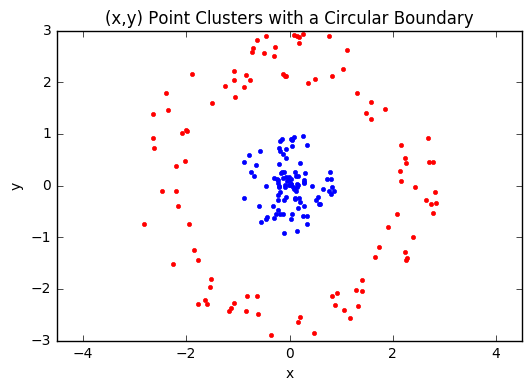

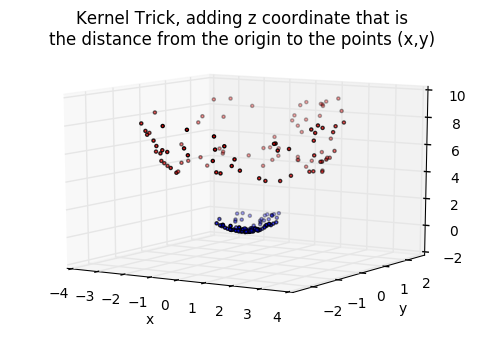

In [12]:
from mpl_toolkits.mplot3d import Axes3D
def show_kernel_trick_figure():
    num_points = 100
    r = np.random.rand(num_points,1)
    theta = np.random.rand(num_points,1)*2.*np.pi
    x1 = r*np.cos(theta)
    y1 = r*np.sin(theta)
    z1 = x1**2 + y1**2
    x2 = (r+2)*np.cos(theta)
    y2 = (r+2)*np.sin(theta)
    z2 = x2**2 + y2**2
    plt.figure()
    plt.plot(x1,y1,'b.', x2, y2, 'r.')
    plt.axis('equal')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('(x,y) Point Clusters with a Circular Boundary')

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x1, y1, z1, c='b', marker='.')
    ax.scatter(x2, y2, z2, c='r', marker='.')
    ax.view_init(11,-58)
    ax.axis('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.title('Kernel Trick, adding z coordinate that is\nthe distance from the origin to the points (x,y)')
    
    plt.show()
show_kernel_trick_figure()

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.gridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier you've chosen and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

In [13]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.neighbors import KNeighborsClassifier
from sklearn import grid_search
from sklearn.metrics import make_scorer

# TODO: Create the parameters list you wish to tune
parameters = {'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'algorithm':['SAMME', 'SAMME.R']}

# TODO: Initialize the classifier
clf = AdaBoostClassifier(random_state=42)

# # TODO: Create the parameters list you wish to tune
# parameters = {'n_neighbors':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'weights':['uniform', 'distance'], 'p':[1, 2]}

# # TODO: Initialize the classifier
# clf = KNeighborsClassifier()

# # TODO: Create the parameters list you wish to tune
# parameters = {'degree' : [1, 2, 3, 4, 5], 'kernel': ['poly', 'rbf'], 'gamma' : np.arange(0,1,0.1)}
# # TODO: Initialize the classifier
# clf = SVC()

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score, pos_label=1)

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = grid_search.GridSearchCV(clf, parameters, f1_scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))

Made predictions in 0.2440 seconds.
Tuned model has a training F1 score of 0.9122.
Made predictions in 0.0920 seconds.
Tuned model has a testing F1 score of 0.8957.


In [14]:
import pickle
pickle.dump(clf, open("classifier.p", "wb"))


In [15]:
def write_poly_file(out_file, num_vertices, cloud_points):
    out_file.write("ply\n")
    out_file.write("format ascii 1.0\n")
    vertex_string = str()
    vertex_string = "element vertex " + str(num_vertices) + "\n"
    out_file.write(vertex_string)
    out_file.write("property float x\n")
    out_file.write("property float y\n")
    out_file.write("property float z\n")
    out_file.write("property float intensity\n")
    out_file.write("end_header\n")

    for point in cloud_points:
        if point is not None:
            line = str(point[0]) + ' ' + str(point[1]) + ' ' +  str(point[2]) + ' ' +  str(point[3]) + '\n'
            out_file.write(line)

def write_poly_file2(file_name, cloud_points):

    out_file = file(file_name, 'w')
    num_vertices = 0
    for point in cloud_points:
        if point is not None:
            num_vertices += 1

    write_poly_file(out_file, num_vertices, cloud_points)
    
    out_file.close()



In [16]:
from mpl_toolkits.mplot3d import Axes3D
def plot_classified_points(classified_point_cloud):
    colors = ['b.','r.','g.','k.','m.']
    fig = plt.gcf()
    for i in range(min(classified_point_cloud['class_id']), max(classified_point_cloud['class_id'])+1):
        class_points = classified_point_cloud.loc[classified_point_cloud['class_id']== i]

        plt.plot(-class_points['y'], class_points['z'], colors[i])


In [17]:
def classify_and_plot_file(clf, point_cloud_file_name):
    data = pc.calculate_point_cloud_features(point_cloud_file_name)
    # Remove the point cloud x,y,z data from the data frame. Those will not be used as features
    point_cloud_points = data[['x','y','z','intensity']]

    del data['x']
    del data['y']
    del data['z']
    del data['intensity']
    
    X_all = data
    predicted_class = clf.predict(X_all)
    
    classified_point_cloud = point_cloud_points[['x','y','z']]
    classified_point_cloud['class_id'] = predicted_class
    classified_point_cloud['intensity'] = predicted_class

    plot_classified_points(classified_point_cloud)

    point_cloud_points = classified_point_cloud[['x','y','z','class_id']]
    return point_cloud_points


# Training Results

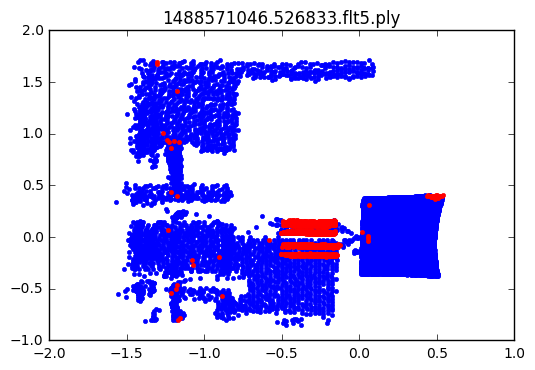

In [18]:
# Plot and output training results
for point_cloud_file_name in point_cloud_file_names:
    plt.figure()
    point_cloud_points = classify_and_plot_file(clf, data_file_path + point_cloud_file_name)
    plt.title(point_cloud_file_name)
    write_poly_file2(point_cloud_file_name[:-9]+".trn.ply", np.array(point_cloud_points))

# Test Results

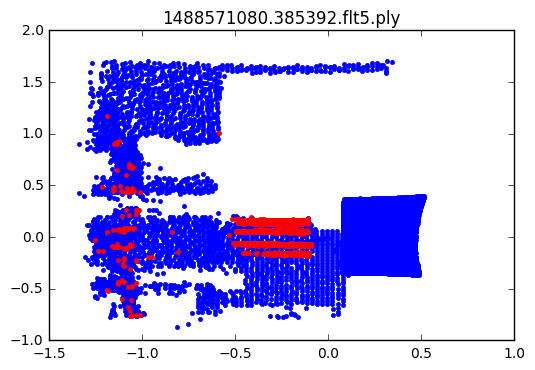

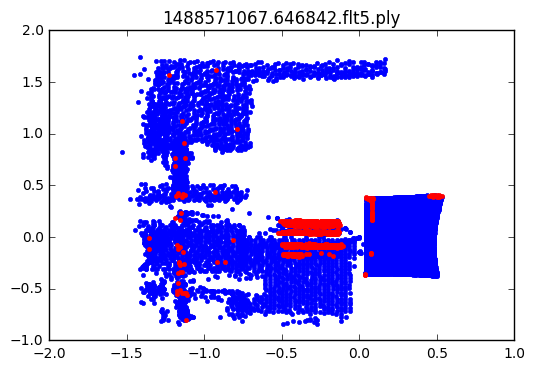

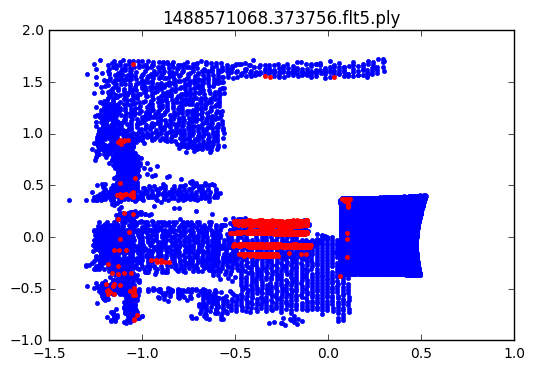

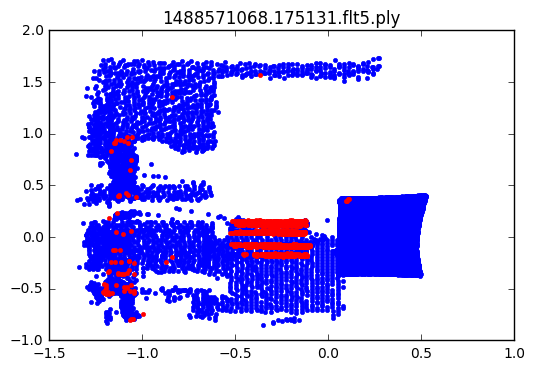

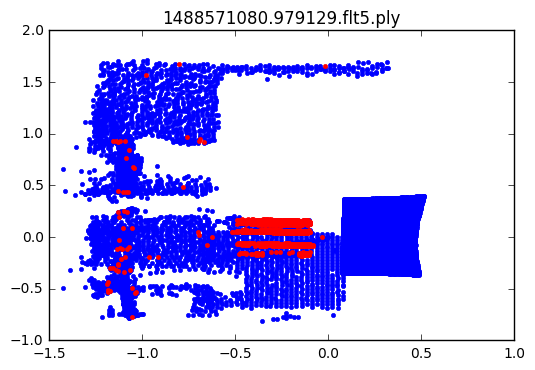

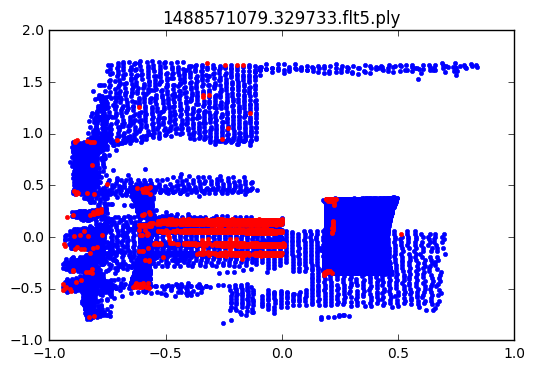

In [19]:
import random
test_file_path = "../data/moving/"
only_files = [f for f in listdir(test_file_path) if isfile(join(test_file_path, f))]
ply_files = [f for f in only_files if f[-9:] == '.flt5.ply']
# Choose 6 test files
random.seed(42)
indices = random.sample(range(len(ply_files)), 6)

ply_files = [ply_files[index] for index in indices]

for point_cloud_file_name in ply_files:
    plt.figure()
    point_cloud_points = classify_and_plot_file(clf, test_file_path + point_cloud_file_name)
    plt.title(point_cloud_file_name)
    write_poly_file2(point_cloud_file_name[:-9] + ".tst.ply", np.array(point_cloud_points))    


In [20]:
# pc.animate_classifier(test_file_path, "classifier.p")


### Question 5 - Final F<sub>1</sub> Score
*What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?*

**Answer: ** The final F1 score for the support vector classifier, after tuning, is 0.795 for the test set. This compares to 0.784 using the default parameters. The additional grid search parameter tuning did not increase the performance by very much. Also, the resulting F1 score for the SVC is not that much greater than the F1 score the Naive Bayes classifier (0.76). Therefore, in the end the Naive Bayes classifier is probably the best choice due to its high computational efficiency. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.